# **Importing libraries**

In [3]:
!pip install backtrader
!pip install ta

     |████████████████████████████████| 419kB 18.5MB/s 
  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=85dc366e297444085f849f5eef4aea2b1c33690fb49b3486e59cfee47dd97ec8
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


In [4]:
from __future__ import (absolute_import, division, print_function,unicode_literals)
from sklearn.utils import shuffle
import backtrader as bt
import math
import ta
from statistics import mean
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib
import keras
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , BatchNormalization , GRU ,LeakyReLU
from tensorflow.keras.layers import LSTM , Conv1D
from tensorflow.keras.layers import Dropout ,Flatten 
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , TensorBoard
from imblearn.under_sampling import ClusterCentroids

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# **Loading Dataset from Google Drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import minute data**

In [89]:
df = pd.read_csv('/content/drive/MyDrive/agr/eurusd_minute.csv',usecols = ['Date', 'Time' ,'BO','BH','BL','BC'], parse_dates = [[0, 1]], date_parser=lambda col: pd.to_datetime(col, utc=False),nrows = 100000)

# **Calculate Signal**

In [147]:
pip = 10
timeframe = 30
lookback_period  = 100
BATCH_SIZE = 32
lstm_units = 7
lr = 0.000001
epoches = 300
dx = 	pip/10000
df['TimeframeDiff'] = df['BC'] - df['BC'].shift(timeframe)
df['TimeframeDiff'] = df['TimeframeDiff'].shift(-timeframe,fill_value = 0)
df['Signal'] = np.select([df['TimeframeDiff'] > dx,df['TimeframeDiff']<-dx],[1,-1],default = 0)

# **Import Features**

In [148]:
from ta.trend import sma_indicator as sma
sma_close = sma(df['BC'] , 10,fillna= True)

In [149]:
from ta.trend import macd
macd_close = macd(df['BC'],window_fast = 12, window_slow = 26,fillna = True)

In [150]:
from ta.trend import cci
cci_close = cci(df['BH'],df['BL'], df['BC'] , window = 20 , fillna = True)

In [151]:
from ta.momentum import roc
roc_close = roc(df['BC'],window = 2,fillna= True)

In [152]:
from ta.momentum import rsi
rsi_close  = rsi(df['BC'] ,window = 14, fillna = True) 

In [153]:
from ta.volatility import bollinger_mavg as bb
bb_close  = bb(df['BC'] , window = 20 , fillna = True)

In [154]:
feature_list  = [df['TimeframeDiff'],sma_close , macd_close , roc_close , rsi_close , bb_close , cci_close ]

# **Combining all features together to input array**

In [155]:
Combination = pd.concat(feature_list,axis = 1)

Combination.fillna(0, inplace=True)

In [156]:
Combination_array = pd.DataFrame.to_numpy(Combination)

n_features = Combination_array.shape[1]

In [157]:
data = Combination_array

In [158]:
plot_data = data[:, 0]

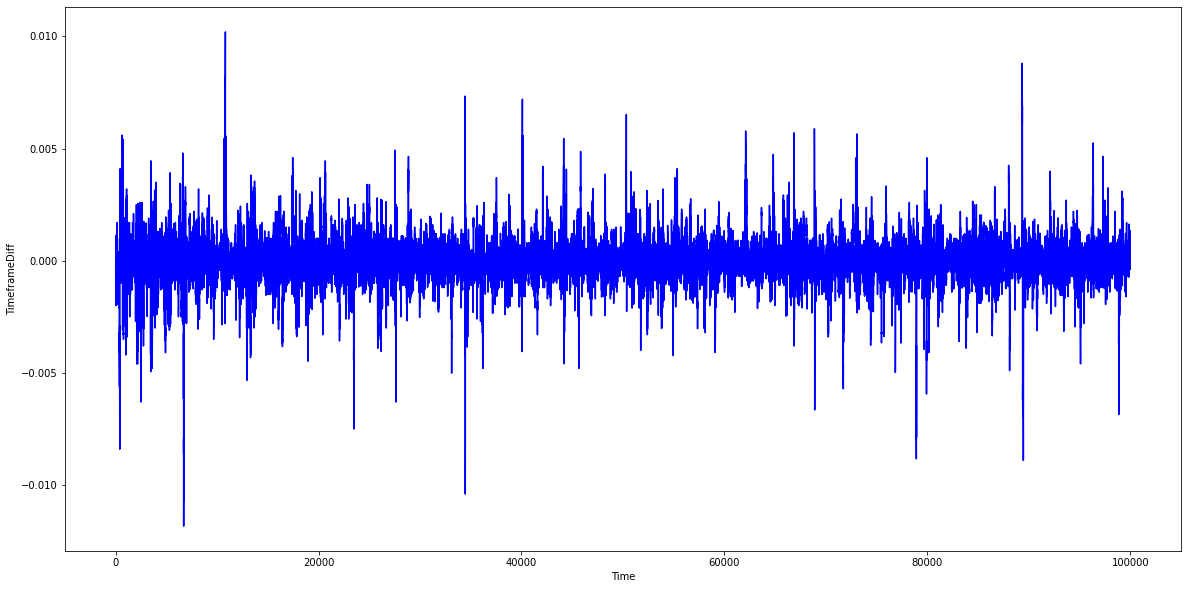

In [159]:
fig = plt.figure(figsize=(20,10))
plt.ylabel("TimeframeDiff")
plt.xlabel("Time")
plt.plot(plot_data, color = 'blue', label = 'Training Set')
plt.show()

In [160]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data[:,0])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -29.368914
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


# **Function for generating data with sliding window**


In [161]:
def data_generator_diff(data, signal,start, finish, lookback_period , timeframe ,dx):
    data = data[start:finish]
    
    X_data = []
    y_data = []
    
    for i in range(0, len(data)-lookback_period-timeframe+1):
        X_data.append(data[i:i+lookback_period-1, :n_features]) 
        if signal[i+lookback_period] == 1:
            y_data.append(2)
        elif signal[i+lookback_period] == -1:
            y_data.append(1)
        else:
            y_data.append(0) 
    
    X_data , y_data = np.array(X_data), np.array(y_data)

        
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], n_features)) 
    
    sc = MinMaxScaler(feature_range = (0, 1))
    
    for i in range(X_data.shape[0]):
        temp = X_data[i,:,0].reshape(-1,1)
        temp = sc.fit_transform(temp)
        X_data[i,:,0] = temp[:,0]
    
    return X_data , y_data

In [162]:
signal = df['Signal'].values

# **Generate train set and test set**

In [171]:
train_start = 0
train_end = math.floor(0.8*Combination_array.shape[0])
val_start = train_end
val_end = math.floor(0.9*Combination_array.shape[0])
test_start = val_end
test_end = Combination_array.shape[0]
X_train , y_train = data_generator_diff(data,signal, train_start, train_end , lookback_period ,timeframe , dx)
X_val , y_val  = data_generator_diff(data,signal, val_start, val_end , lookback_period ,timeframe , dx)
X_test , y_test = data_generator_diff(data,signal, test_start, test_end, lookback_period ,timeframe,dx)

# **Shuffle train data**

In [172]:
X_train, y_train = shuffle(X_train, y_train)

# **Plotting**

# **Plotting train and test set**

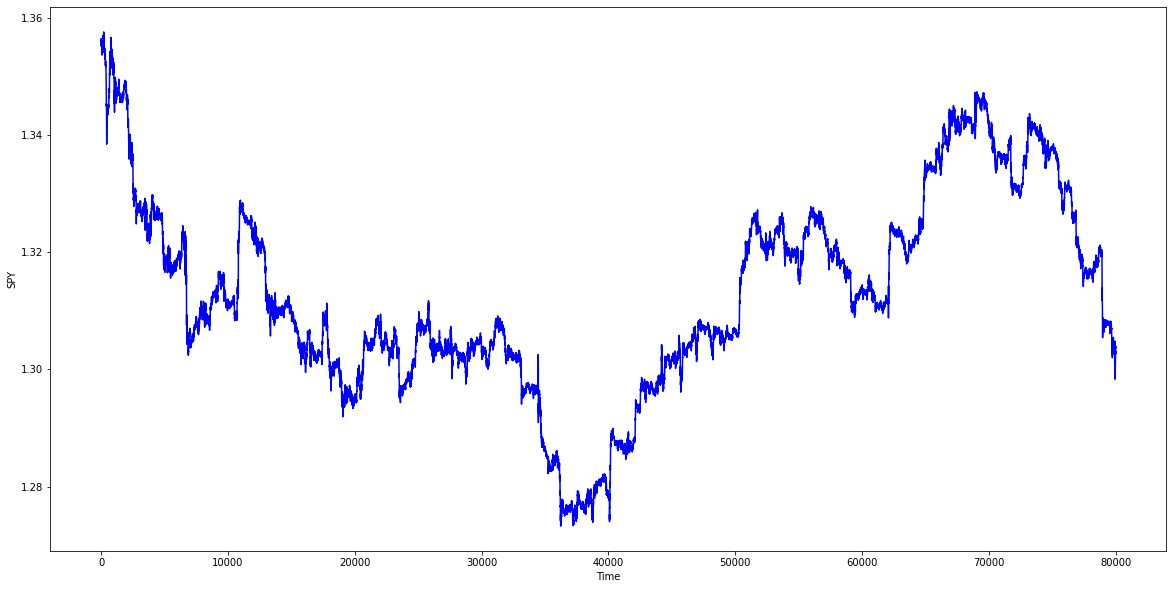

In [173]:
train_set = df.iloc[train_start:train_end , [3]]

fig = plt.figure(figsize=(20,10))
plt.ylabel("SPY")
plt.xlabel("Time")
plt.plot(train_set, color = 'blue', label = 'Training Set')
plt.show()

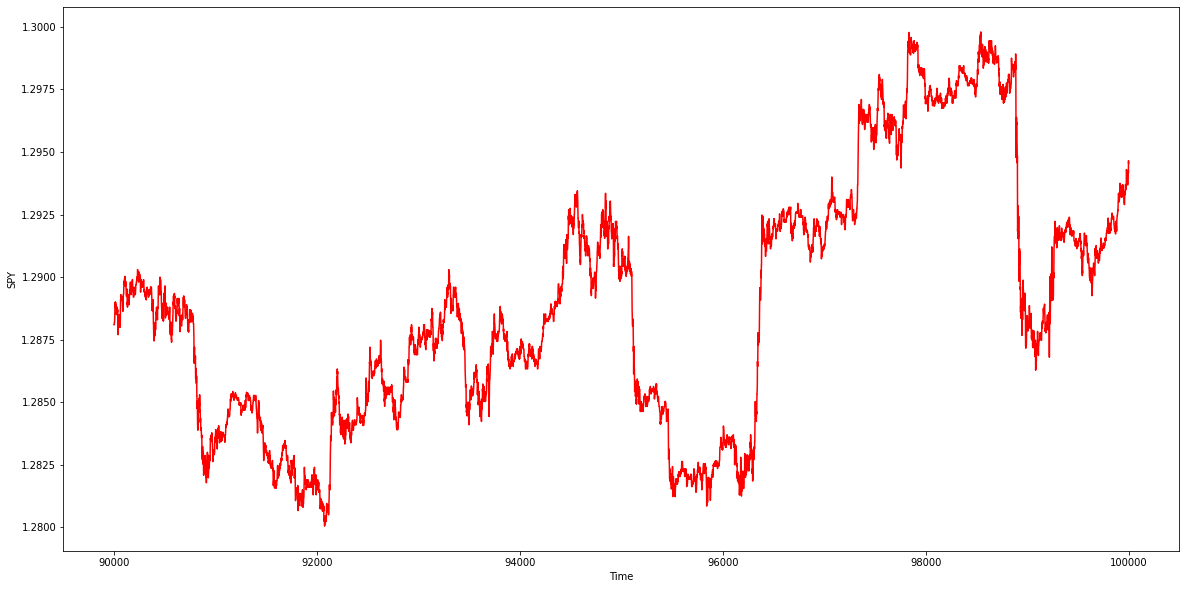

In [174]:
test_set = df.iloc[test_start:test_end , [3]]

fig = plt.figure(figsize=(20,10))
plt.ylabel("SPY")
plt.xlabel("Time")
plt.plot(test_set, color = 'red', label = 'Test Set')
plt.show()

# **Training the network**

# **Model Architecture**

In [175]:
model = Sequential()

model.add(LSTM(units= lstm_units,input_shape = (X_train.shape[1],n_features)))
model.add(Dropout(0.1))

model.add(Dense(units = 3,activation = 'softmax'))

opt = tf.keras.optimizers.Adam(learning_rate= lr)

model.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['acc'])

print(model.summary())

es = EarlyStopping(monitor = 'val_acc', mode= 'auto',patience=10)

my_callbacks = [es]

history = model.fit(X_train, y_train 
          ,epochs = epoches
          ,batch_size = BATCH_SIZE
          ,validation_data=(X_val, y_val)
          ,callbacks = my_callbacks
          )

model.save('/content/drive/MyDrive/agr/Models/my_model.h5')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_10 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 24        
Total params: 444
Trainable params: 444
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
2496/2496 [==============================] - 15s 5ms/step - loss: 1.3264 - acc: 0.1188 - val_loss: 1.2740 - val_acc: 0.1606
Epoch 2/300
2496/2496 [==============================] - 13s 5ms/step - loss: 1.3185 - acc: 0.1219 - val_loss: 1.2675 - val_acc: 0.1607
Epoch 3/300
2496/2496 [==============================] - 14s 6ms/step - loss: 1.3113 - acc: 0.1227 - val_los

# **Plotting losses and accuracy**

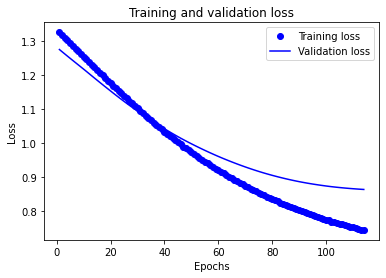

In [176]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

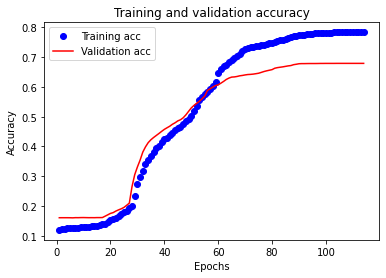

In [177]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Accuracy-Loss on Test set**

In [178]:
results = model.evaluate(X_test, y_test, batch_size= BATCH_SIZE)
print("test loss, test acc:", results)

309/309 [==============================] - 1s 3ms/step - loss: 0.8670 - acc: 0.6791
test loss, test acc: [0.8669915199279785, 0.6790598630905151]
